## HomeWork 5

За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою.

- Для використання алгоритму SVM та Random Forest створимо датасет з часовими ознаками файлів з датасету (min, max, mean, std)

In [102]:
import os
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [101]:
def compute_features(file_path):
    df = pd.read_csv(file_path)
    features = {
        'min_X': df['accelerometer_X'].min(),
        'max_X': df['accelerometer_X'].max(),
        'mean_X': df['accelerometer_X'].mean(),
        'std_X': df['accelerometer_X'].std(),
        'min_Y': df['accelerometer_Y'].min(),
        'max_Y': df['accelerometer_Y'].max(),
        'mean_Y': df['accelerometer_Y'].mean(),
        'std_Y': df['accelerometer_Y'].std(),
        'min_Z': df['accelerometer_Z'].min(),
        'max_Z': df['accelerometer_Z'].max(),
        'mean_Z': df['accelerometer_Z'].mean(),
        'std_Z': df['accelerometer_Z'].std(),
    }
    return features

In [103]:
data_folder = '/content/drive/MyDrive/Colab Notebooks/Data_hw5'
activities = {'idle': 1, 'running': 2, 'stairs': 3, 'walking': 4}
data = []

for activity, value in activities.items():
    activity_folder = f'{data_folder}/{activity}'
    for file_name in os.listdir(activity_folder):
        file_path = f'{activity_folder}/{file_name}'
        features = compute_features(file_path)
        features['activity'] = activity
        features['activity_num'] = value
        data.append(features)

In [19]:
df = pd.DataFrame(data)
df.head()

,min_X,max_X,mean_X,min_Y,max_Y,mean_Y,min_Z,max_Z,mean_Z,activity,activity_num
0,-1.283292,-0.148441,-0.790565,1.230620,2.954445,2.330835,8.298303,10.141838,9.400434,idle,1
1,-0.263362,5.755661,0.609564,-2.557007,9.179369,0.897028,3.026271,9.911995,9.167718,idle,1
2,0.134075,0.301669,0.244528,-0.124498,0.028730,-0.030167,9.720459,9.797073,9.765630,idle,1
3,0.014365,0.632069,0.241016,-0.095768,0.162806,-0.005427,9.586384,9.797073,9.751264,idle,1
4,0.244209,0.339977,0.273099,-0.138864,0.033519,-0.070389,9.720459,9.868899,9.770258,idle,1
...,...,...,...,...,...,...,...,...,...,...,...
6457,-9.504981,7.527370,-1.742340,-23.376986,3.423709,-10.166738,-26.302700,21.648373,-1.533406,walking,4
6458,-15.088259,4.141969,-4.243802,-17.980455,-1.470040,-10.040005,-14.695610,17.712305,-1.210508,walking,4
6459,-11.247959,1.010353,-3.037603,-23.376986,0.416591,-9.954133,-9.457097,20.944477,-0.826319,walking,4
6460,-13.225570,4.486734,-2.777912,-26.307487,4.951209,-9.039707,-17.353174,11.832145,-1.515210,walking,4


- Визначимо тестову вибірку та знайдемо найкращу модель SVM за допомогою GridSearchCV

In [86]:
X = df.drop(['activity_num', 'activity'], axis=1)
y = df['activity_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, train_size=0.7, random_state=42)

svm_classifier = SVC()
svm_param_grid = {'C': [0.1, 1.0, 10.0, 100.0],
                  'kernel': ['linear', 'rbf', 'poly'],
                  'gamma': ['scale', 'auto']}
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)

best_svm_params = svm_grid_search.best_params_
best_svm_model = svm_grid_search.best_estimator_

In [88]:
print(best_svm_params)
print(best_svm_model)

{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
SVC(C=100.0)


- Знайдемо найкращу модель Random Forest за допомогою GridSearchCV

In [92]:
rf_classifier = RandomForestClassifier()
rf_param_grid = {'n_estimators': [50, 100, 200],
                 'max_depth': [None, 10, 20, 30],
                 'min_samples_split': [2, 5, 10]}

rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)

best_rf_params = rf_grid_search.best_params_
best_rf_model = rf_grid_search.best_estimator_

In [71]:
print(best_rf_params)
print(best_rf_model)

{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
RandomForestClassifier(max_depth=15, n_estimators=50)


- Знайдемо показники точності та F1 для алгоритмів SVM та Random Forest

In [104]:
svm_preds = best_svm_model.predict(X_test)
rf_preds = best_rf_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

svm_f1 = f1_score(y_test, svm_preds, average='weighted')
rf_f1 = f1_score(y_test, rf_preds, average='weighted')

print(f'SVM accuracy: {svm_accuracy}')
print(f'Random Forest accuracy: {rf_accuracy}')
print(f'SVM F1: {svm_f1}')
print(f'Random Forest F1: {rf_f1}')

SVM accuracy: 0.9948453608247423
Random Forest accuracy: 0.9989690721649485
SVM F1: 0.9947901696048265
Random Forest F1: 0.9989795741203024


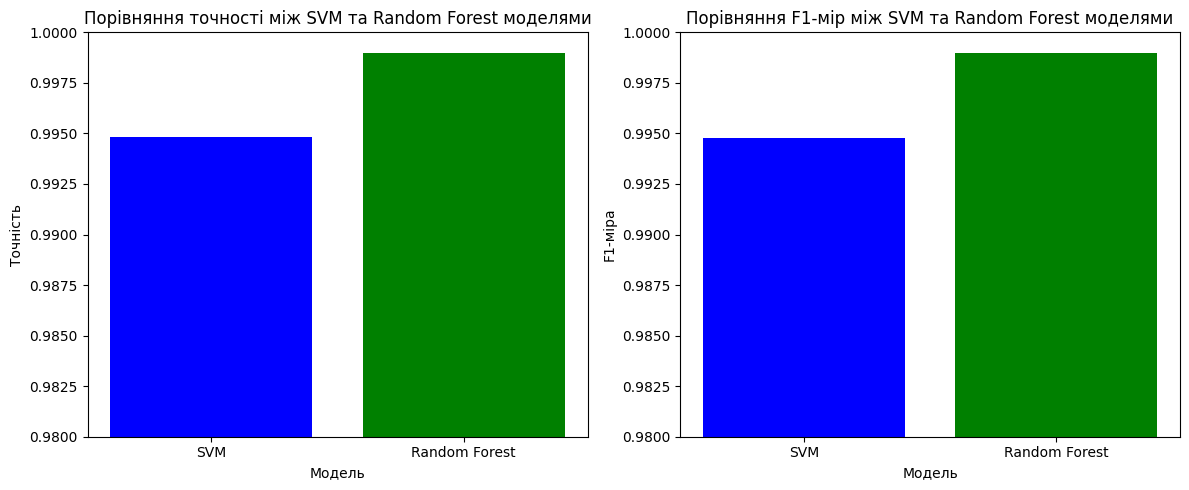

In [95]:
import matplotlib.pyplot as plt

accuracies = [svm_accuracy, rf_accuracy]
f1_scores = [svm_f1, rf_f1]

models = ['SVM', 'Random Forest']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(models, accuracies, color=['blue', 'green'])
axs[0].set_xlabel('Модель')
axs[0].set_ylabel('Точність')
axs[0].set_title('Порівняння точності між SVM та Random Forest моделями')
axs[0].set_ylim(0.98, 1.0)

axs[1].bar(models, f1_scores, color=['blue', 'green'])
axs[1].set_xlabel('Модель')
axs[1].set_ylabel('F1-міра')
axs[1].set_title('Порівняння F1-мір між SVM та Random Forest моделями')
axs[1].set_ylim(0.98, 1.0)

plt.tight_layout()
plt.show()


**Висновок:** *В цілому, обидві моделі досягли високої точності та F1-міри, що свідчить про їхню хорошу роботу у класифікації діяльностей на основі даних акселерометра. Але модель Random Forest має невелику перевагу над моделлю SVM у цьому конкретному наборі даних.*